# Summary

In [1]:
%load_ext autoreload

import os
import numpy as np
import scipy.io as sio

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import zscore

import flygenvectors.plotting as plotting
import flygenvectors.utils as utils
import flygenvectors.ssmutils as ssmutils
import flygenvectors.data as dataUtils
from flygenvectors.dlc import DLCLabels

In [2]:
plot_dark = False

sns.set_context('talk')
if plot_dark:
    plt.style.use('dark_background')
#     cmap_rasters = 'inferno'
    cmap_rasters = 'afmhot'
else:
    sns.set_style('white')
    cmap_rasters = 'Greys'

# 1. Load and preprocess data

In [30]:
# options
# expt_id = '190424_f3'  # (run+feed)
# expt_id = '180824_f3r1'
# expt_id = '2019_06_26_fly2'
# expt_id = '2019_06_28_fly2'
# expt_id = '2019_06_30_fly1'
expt_id = '2019_07_01_fly2'

# preprocessing directives
preprocess_list = {
    'interpolate_labels': {'thresh': 0.8, 'window': 3}, # "bad" labels replaced with avg of neighboring "good" labels
    # 'standardize': {}, # zscore labels
    'unitize': {}, # scale labels in [0, 1]
    'filter': {'type': 'median', 'window_size': 5},
    'remove_bad_runs': {'thresh': 0.8, 'min_length': 10} # remove runs where at least one label is "bad"
}
do_fit_differences = False  # fit label differences rather than original labels

# load and preprocess dlc labels
dlc_obj = DLCLabels(expt_id)
dlc_obj.load_from_csv()
dlc_obj.preprocess(preprocess_list)

# split labels into train/test/val
dlc_obj.extract_runs_by_likelihood(
    likelihoods=dlc_obj.labels['l'], l_thresh=0.0, min_length=100, max_length=500, 
    skip_idxs=dlc_obj.skip_idxs)
dlc_obj.split_labels(
    dtypes=['train', 'test', 'val'], dtype_lens=[5, 0, 1], diff=do_fit_differences)

# define model dir based on preprocessing
model_dir = 'dlc-arhmm'
if do_fit_differences:
    model_dir += '-diff'
print('\nsaving models in the following directory: "%s"' % model_dir)

loading labels from /media/mattw/data/schaffer/2019_07_01_fly2/2019_07_01_fly2DeepCut_resnet50_RunningJul3shuffle1_1030000.csv...done
total time points: 192980
linearly interpolating labels (window=3)...done
linearly interpolated 16958 labels
unitizing labels...done
extracting runs of labels <= likelihood=0.80...done
extracted 558 runs for a total of 14404 time points
removing 14404 low-likelihood time points
extracting runs of labels >= likelihood=0.00...done
extracted 387 runs for a total of 169812 time points
splitting labels into ['train', 'test', 'val']...done
	train: 141726 time points in 323 trials
	test: 0 time points in 0 trials
	val: 28086 time points in 64 trials

saving models in the following directory: "dlc-arhmm"


### check outliers

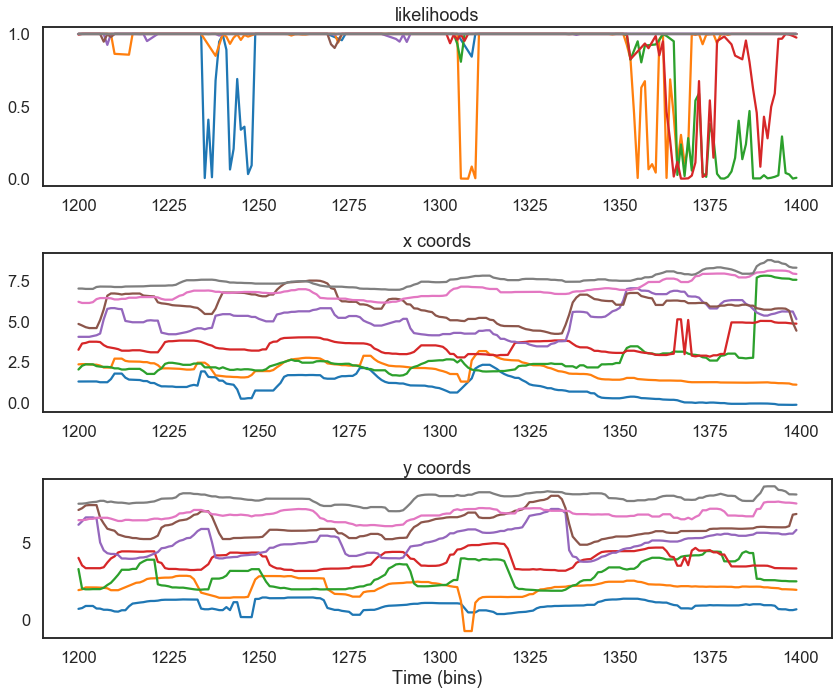

In [4]:
# # plot dlc labels/likelihoods over time
# slc = (1200, 1400)
# plot_diffs = False
# frac = 20 

# plt.figure(figsize=(12, 10))

# plt.subplot(311)
# plt.plot(np.arange(slc[0], slc[1]), dlc_obj.labels['l'][slice(*slc), :])
# plt.title('likelihoods')

# plt.subplot(312)
# coord = 'x'
# behavior = frac * dlc_obj.labels[coord] / np.max(np.abs(dlc_obj.labels[coord])) + \
#     np.arange(dlc_obj.labels[coord].shape[1])
# if plot_diffs:
#     behavior = np.concatenate(
#         [np.zeros(shape=(1, behavior.shape[1])), np.diff(behavior, axis=0)])
# plt.plot(np.arange(slc[0], slc[1]), behavior[slice(*slc), :])
# plt.title('%s coords' % coord)

# plt.subplot(313)
# coord = 'y'
# behavior = frac * dlc_obj.labels[coord] / np.max(np.abs(dlc_obj.labels[coord])) + \
#     np.arange(dlc_obj.labels[coord].shape[1])
# if plot_diffs:
#     behavior = np.concatenate(
#         [np.zeros(shape=(1, behavior.shape[1])), np.diff(behavior, axis=0)])
# plt.plot(np.arange(slc[0], slc[1]), behavior[slice(*slc), :])
# plt.title('%s coords' % coord)

# plt.xlabel('Time (bins)')
# plt.tight_layout()
# plt.show()

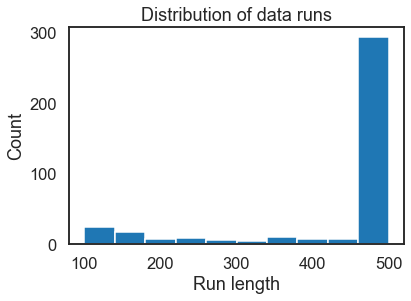

In [5]:
# plot distribution of run lengths
import matplotlib.pyplot as plt
plt.figure()
plt.hist([len(i) for i in dlc_obj.idxs_valid])
plt.xlabel('Run length')
plt.ylabel('Count')
plt.title('Distribution of data runs')
plt.show()

# 2. Fit dynamics

### ARHMM - how many discrete states?

In [60]:
# %autoreload 2
# import flygenvectors.ssmutils as ssmutils
# n_states = [2, 3, 4, 5, 6, 9, 12, 15, 18]
n_states = [9]
D = dlc_obj.labels_dict['train'][0].shape[1]
sticky_lags = 3
model_kwargs = {
#     'hmm': {
#         'transitions': 'standard', 
#         'observations': 'gaussian'},
#     'arhmm-s2-%i' % sticky_lags: {
#         'transitions': 'sticky', 
#         'transition_kwargs': {'kappa': 1e2},
#         'observations': 'ar',
#         'observation_kwargs': {'lags': sticky_lags}},
#     'arhmm-s4-%i' % sticky_lags: {
#         'transitions': 'sticky', 
#         'transition_kwargs': {'kappa': 1e4},
#         'observations': 'ar',
#         'observation_kwargs': {'lags': sticky_lags}},
#     'arhmm-s6-%i' % sticky_lags: {
#         'transitions': 'sticky', 
#         'transition_kwargs': {'kappa': 1e6},
#         'observations': 'ar',
#         'observation_kwargs': {'lags': sticky_lags}},
#     'arhmm-s8-%i' % sticky_lags: {
#         'transitions': 'sticky', 
#         'transition_kwargs': {'kappa': 1e8},
#         'observations': 'ar',
#         'observation_kwargs': {'lags': sticky_lags}},
    'arhmm-1': {
        'transitions': 'standard', 
        'observations': 'ar',
        'observation_kwargs': {'lags': 1}},
#     'arhmm-2': {
#         'transitions': 'standard', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 2}},
#     'arhmm-3': {
#         'transitions': 'standard', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 3}},
#     'arhmm-5': {
#         'transitions': 'standard', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 5}},
#     'arhmm-7': {
#         'transitions': 'standard', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 7}},
}

fit_kwargs = {
    'save': True,
    'load_if_exists': True,
    'expt_id': expt_id,
    'model_dir': model_dir,
    'save_dir': None}

all_results = {}
# iterate over model types
for model_name, kwargs in model_kwargs.items():
#     if model_name in all_results and len(all_results[model_name] == n_states):
#         continue
    model_results = {}
    # iterate over discrete states
    for K in n_states:
        print('Fitting %s with %i states' % (model_name, K))
        model_results[K] = ssmutils.fit_model(
            n_states=K, data_dim=D, input_dim=0, model_kwargs=kwargs,
            data_tr=dlc_obj.labels_dict['train'], 
            data_val=dlc_obj.labels_dict['val'],
            data_test=dlc_obj.labels_dict['test'],
            fit_kwargs=fit_kwargs)
    all_results[model_name] = model_results

Fitting arhmm-1 with 2 states
loading model from /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=1_K=02.pkl
Fitting arhmm-1 with 3 states
loading model from /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=1_K=03.pkl
Fitting arhmm-1 with 4 states
loading model from /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=1_K=04.pkl
Fitting arhmm-1 with 5 states
loading model from /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=1_K=05.pkl
Fitting arhmm-1 with 6 states
loading model from /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=1_K=06.pkl
Fitting arhmm-1 with 9 states
loading model from /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=1_K=09.pkl
Fitting arhmm-1 with 12 states
loading model from /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=1_K=12.pkl
Fitting arhmm-1 with 15 states
loading m

saving model to /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=2_K=02.pkl
Fitting arhmm-2 with 3 states


saving model to /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=2_K=03.pkl
Fitting arhmm-2 with 4 states


saving model to /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=2_K=04.pkl
Fitting arhmm-2 with 5 states


saving model to /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=2_K=05.pkl
Fitting arhmm-2 with 6 states


saving model to /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=2_K=06.pkl
Fitting arhmm-2 with 9 states


saving model to /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=2_K=09.pkl
Fitting arhmm-2 with 12 states


saving model to /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=2_K=12.pkl
Fitting arhmm-2 with 15 states


saving model to /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=2_K=15.pkl
Fitting arhmm-2 with 18 states


saving model to /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=2_K=18.pkl
Fitting arhmm-3 with 2 states
loading model from /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=3_K=02.pkl
Fitting arhmm-3 with 3 states
loading model from /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=3_K=03.pkl
Fitting arhmm-3 with 4 states
loading model from /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=3_K=04.pkl
Fitting arhmm-3 with 5 states
loading model from /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=3_K=05.pkl
Fitting arhmm-3 with 6 states
loading model from /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=3_K=06.pkl
Fitting arhmm-3 with 9 states
loading model from /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/obs=ar_trans=standard_lags=3_K=09.pkl
Fitting arhmm-3 with 12 states
loading model from /home/mattw/results/fly/

In [42]:
fig = plotting.plot_validation_likelihoods(
    all_results=all_results, 
    T_val=np.sum([d.shape[0] for d in dlc_obj.labels_dict['val']]))
plt.legend(loc='lower right', frameon=False)

NameError: name 'all_results' is not defined

# 3. Probe learned dynamics

In [87]:
# choose model
K = 9
n_lags = 5
model_name = str('arhmm-%i' % n_lags)
dtype = 'train'
arhmm = all_results[model_name][K]['model']
# get most likely states
states_all = [arhmm.most_likely_states(d) for d in dlc_obj.labels_dict[dtype]]

In [ ]:
# state usage plot

In [79]:
print(1.25/3)
print(1.50/4)
print(1.75/5)

0.4166666666666667
0.375
0.35


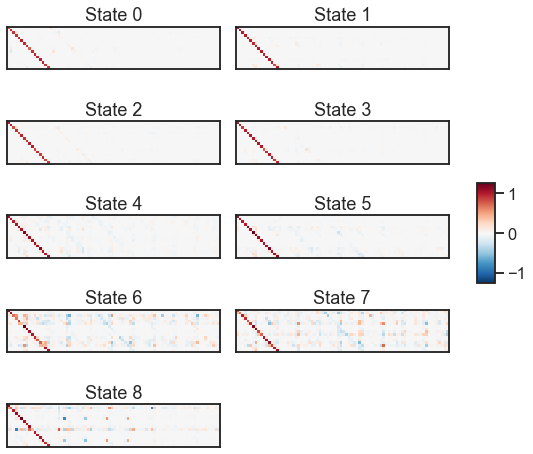

In [89]:
%autoreload
fig = plotting.plot_dynamics_matrices(arhmm, deridge=False)

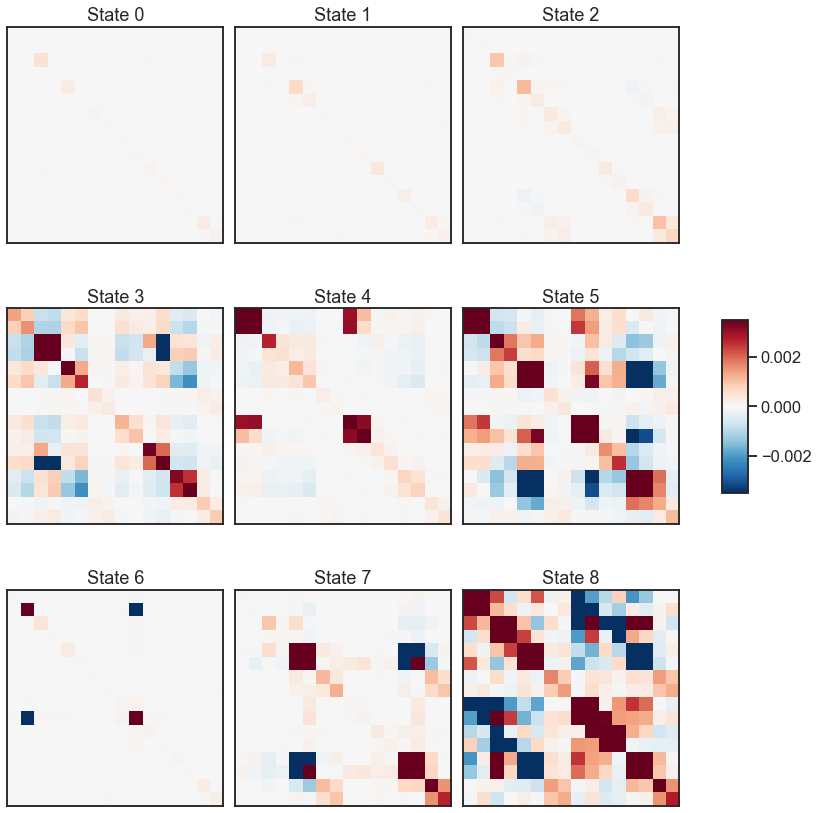

In [44]:
fig = plotting.plot_covariance_matrices(arhmm)

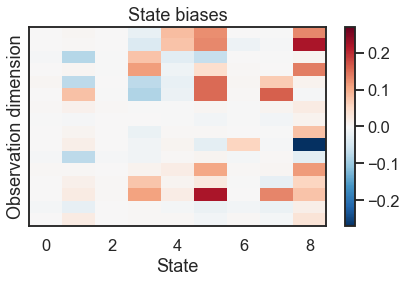

In [45]:
fig = plotting.plot_biases(arhmm)

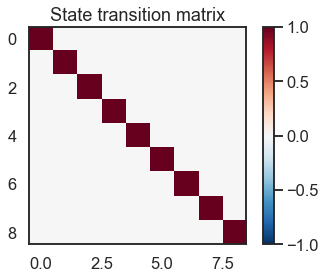

In [46]:
fig = plotting.plot_state_transition_matrix(arhmm)

### find multiple snippets of validation data for each state

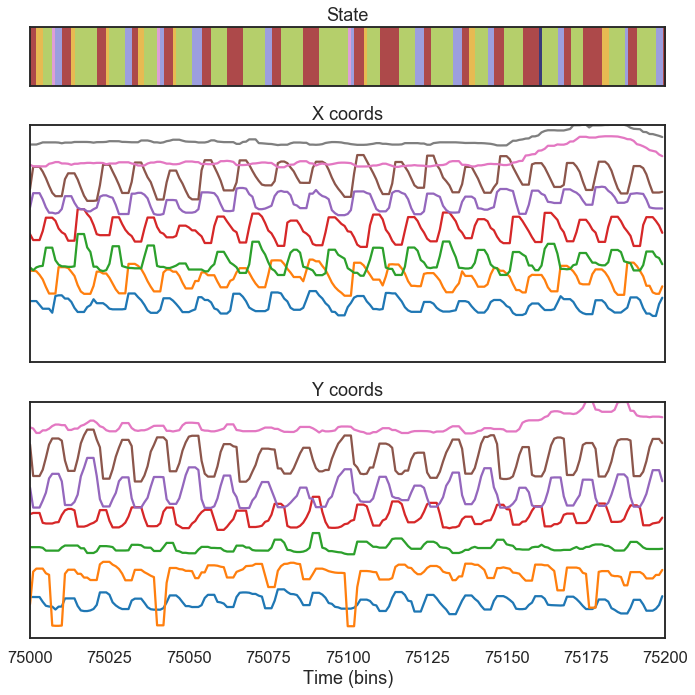

In [57]:
# infer all states and plot dlc lablels
states_ = arhmm.most_likely_states(dlc_obj.get_label_array())
slc = (75000, 75200)
fig = plotting.plot_dlc_arhmm_states(
    dlc_labels=dlc_obj.labels, state_probs=None, states=states_, slc=slc)

In [14]:
# import pickle
# data = {
#     'states_train': [arhmm.most_likely_states(d) for d in dlc_obj.labels_dict['train']],
#     'states_val': [arhmm.most_likely_states(d) for d in dlc_obj.labels_dict['val']],
#     'idxs_train': dlc_obj.idxs_dict['train'],
#     'idxs_val': dlc_obj.idxs_dict['val']}
# with open('/home/mattw/results/fly/arhmm_dlc_states.pkl', 'wb') as f:
#     pickle.dump(data, f)

In [58]:
# collect all state snippets
indx_snippets = ssmutils.extract_state_runs(
    states_all, dlc_obj.idxs_dict[dtype], min_length=2)

# get dlc labels
dlc_snippets = [{'x': [], 'y': []} for _ in range(K)]
state_lengths = [[] for _ in range(K)]
for k, k_indxs in enumerate(indx_snippets):
    for k_indx in k_indxs:
        state_lengths[k].append(len(k_indx))
        for coord in ['x', 'y']:
            dlc_snippets[k][coord].append(dlc_obj.labels[coord][k_indx])        
state_lengths = [np.array(state_lengths[k]) for k in range(K)]

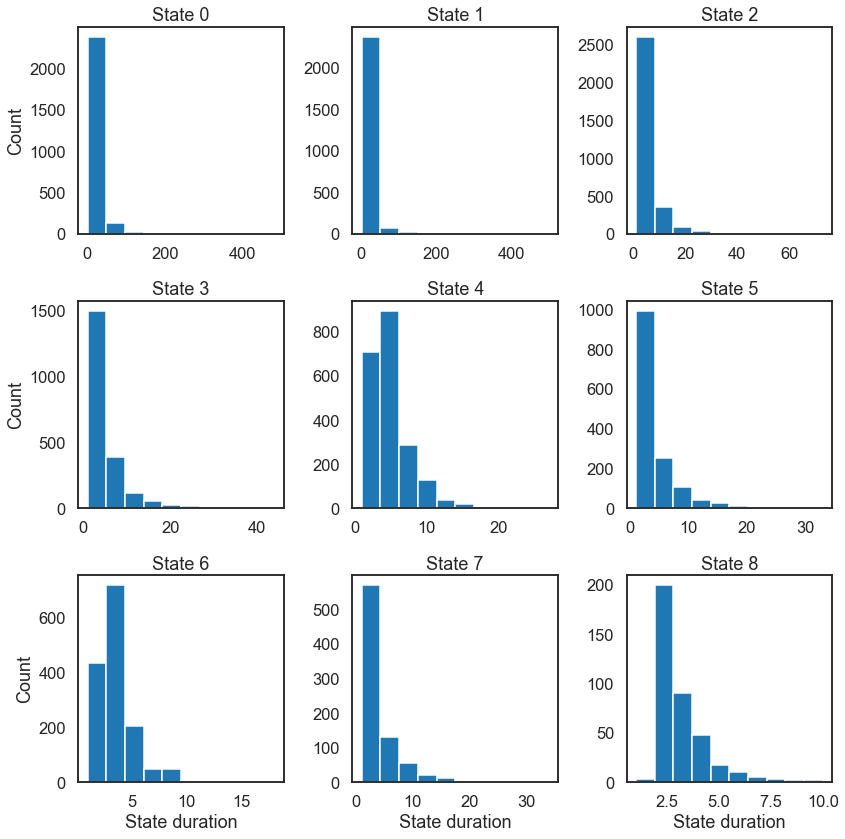

In [59]:
# plot distribution of state durations
n_cols = 3
n_rows = np.ceil(K / n_cols)

fig = plt.figure(figsize=(4 * n_cols, 4 * n_rows))

for i, slens in enumerate(state_lengths):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.hist(slens) #, range=(0, 100))
    plt.title(str('State %i' % i))
    if plt.gca().is_first_col():
        plt.ylabel('Count')
    if plt.gca().is_last_row():
        plt.xlabel('State duration')
plt.tight_layout()
plt.show()

### check for state consistency across lags

In [18]:
# K = 12
# dtype = 'train'
# lags = [1, 2, 3, 5]
# states_ = {l:None for l in lags}

# for lag in lags:
#     if lag == 1:
#         model_name = 'arhmm'
#     else:
#         model_name = str('arhmm-%i' % lag)
#     arhmm = all_results[model_name][K]['model']
#     states_[lag] = arhmm.most_likely_states(dlc_array)

In [19]:
# slc = (75000, 75200)

# fig, axes = plt.subplots(
#     len(lags), 1, figsize=(10, 1.5 * len(lags)),
#     gridspec_kw={'height_ratios': [1 / len(lags)] * len(lags)})

# for i, l in enumerate(lags):
#     axes[i].imshow(states_[l][None, slice(*slc)], aspect='auto', cmap='tab20b')
#     axes[i].set_xticks([])
#     axes[i].set_yticks([])
#     axes[i].set_ylabel('%i lags' % l)
# plt.tight_layout()
# plt.show()

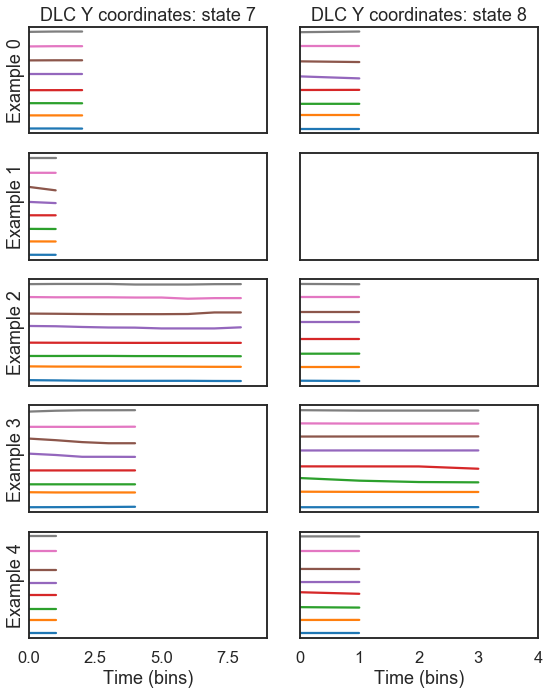

In [50]:
# %autoreload 2
fig = plotting.make_syllable_plots(
    dlc_snippets, max_snippets=5, max_t=100, coord='y', states_to_plot=[7, 8])